In [1]:
import os
import numpy as np
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras import optimizers
from keras.preprocessing import image
from PIL import Image,ImageOps
import cv2
import matplotlib.pyplot as plt

In [2]:
img_rows, img_cols = 32 , 32

In [3]:
isolated_train_path = r'H:\CVPR\bng_isolated_simple\Train'
isolated_test_path = r'H:\CVPR\bng_isolated_simple\Test'

In [4]:
for root, dirnames, filenames in os.walk(isolated_train_path):
    for filename in filenames:
        file_path = os.path.join(root, filename)
        img = Image.open(file_path)
        Grey = img.resize((img_rows, img_cols))
        #img = ImageOps.invert(img)
        #Grey = img.convert('L')
        #ret,thresh1 = cv.threshold(Grey,127,255,cv.THRESH_BINARY)
        #threshold = 105
        #Grey = Grey.point(lambda p: p < threshold and 255)
        #Grey = ImageOps.invert(img)
        Grey = Grey.convert('RGB')
        Grey.save(file_path)

In [5]:
train_data_dir = isolated_train_path
validation_data_dir = isolated_test_path

In [6]:
img_width, img_height, channel = img_rows, img_cols, 3
batch_size = 32

In [7]:
datagen = ImageDataGenerator(rescale=1./255)

#automatically retrive images and their classes for training and validation
train_generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width,img_height),
        batch_size=batch_size,
        shuffle= True,
        class_mode ='categorical')

validation_generator = datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width,img_height),
        batch_size=batch_size,
        shuffle= False,
        class_mode ='categorical')

Found 69244 images belonging to 50 classes.
Found 14824 images belonging to 50 classes.


In [8]:
IMG_SHAPE = img_cols, img_rows, 3
classes = 50

In [9]:
num_epoch = 50
num_train_samples = train_generator.samples
num_validation_samples = validation_generator.samples

print('num_train_samples: ' + str(num_train_samples))
print('num_validation_samples: ' + str(num_validation_samples))

num_train_samples: 69244
num_validation_samples: 14824


In [10]:
import tensorflow
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, BatchNormalization, ReLU, ELU, Dropout, Conv2D, Dense, MaxPool2D, AvgPool2D, GlobalAvgPool2D, Concatenate

In [11]:
def batch_normalization_relu_conv(x, filters, kernel_size):
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
   
    #x =  tensorflow.keras.layers.Dropout(0.1)(x)
    
    return x

In [12]:
def dense_block(tensor, k, reps):
    for _ in range(reps):
        x = batch_normalization_relu_conv(tensor, filters=4*k, kernel_size=1)
        x = batch_normalization_relu_conv(x, filters=k, kernel_size=3)
        #x =  tensorflow.keras.layers.Dropout(0.1)(x)
        tensor = Concatenate()([tensor, x])
    return tensor

In [13]:
def transition_layer(x, theta):
    f = int(tensorflow.keras.backend.int_shape(x)[-1] * theta)
    x = batch_normalization_relu_conv(x, filters=f, kernel_size=1)
    #x =  tensorflow.keras.layers.Dropout(0.1)(x)
    #x = BatchNormalization()(x)
    x = AvgPool2D(pool_size=2, strides=2, padding='same')(x)
    return x

In [14]:
k = 12
theta = 0.5
repetitions = 10, 14, 16
input_layer = Input(IMG_SHAPE)

In [15]:
x = Conv2D(2*k, 7, strides=2, padding='same')(input_layer)
x = Dropout(0.1)(x)
x = MaxPool2D(3, strides=2, padding='same')(x)
#x = BatchNormalization()(x)

In [16]:
d = None
for reps in repetitions:
    d = dense_block(x, k, reps)
    x = transition_layer(d, theta)
    #x = BatchNormalization()(x)
    
#x = BatchNormalization()(x)
x = GlobalAvgPool2D()(d)

output_layer = Dense(classes, activation='softmax')(x)

model = Model(input_layer, output_layer)

In [17]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 16, 16, 24)   3552        ['input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 16, 16, 24)   0           ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 8, 8, 24)     0           ['dropout[0][0]']                
                                                                                              

In [18]:
opt = tensorflow.keras.optimizers.Adam()

In [19]:
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [20]:
history_1= model.fit_generator(train_generator,
                    steps_per_epoch=num_train_samples // batch_size,
                    epochs=50,
                    validation_data=validation_generator,
                    validation_steps=num_validation_samples // batch_size)

Epoch 1/50


C:\Users\va5to\AppData\Local\Temp\ipykernel_11000\193625105.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_1= model.fit_generator(train_generator,


2163/2163 [==============================] - 334s 146ms/step - loss: 0.9137 - accuracy: 0.7423 - val_loss: 0.4923 - val_accuracy: 0.8537
Epoch 2/50
2163/2163 [==============================] - 223s 103ms/step - loss: 0.3755 - accuracy: 0.8915 - val_loss: 0.4815 - val_accuracy: 0.8551
Epoch 3/50
2163/2163 [==============================] - 212s 98ms/step - loss: 0.3021 - accuracy: 0.9135 - val_loss: 0.4858 - val_accuracy: 0.8616
Epoch 4/50
2163/2163 [==============================] - 217s 100ms/step - loss: 0.2624 - accuracy: 0.9236 - val_loss: 0.4010 - val_accuracy: 0.8799
Epoch 5/50
2163/2163 [==============================] - 209s 97ms/step - loss: 0.2310 - accuracy: 0.9329 - val_loss: 0.3614 - val_accuracy: 0.8921
Epoch 6/50
2163/2163 [==============================] - 210s 97ms/step - loss: 0.2067 - accuracy: 0.9391 - val_loss: 0.4561 - val_accuracy: 0.8659
Epoch 7/50
2163/2163 [==============================] - 208s 96ms/step - loss: 0.1834 - accuracy: 0.9446 - val_loss: 0.3430 - 

In [21]:
import seaborn as sns

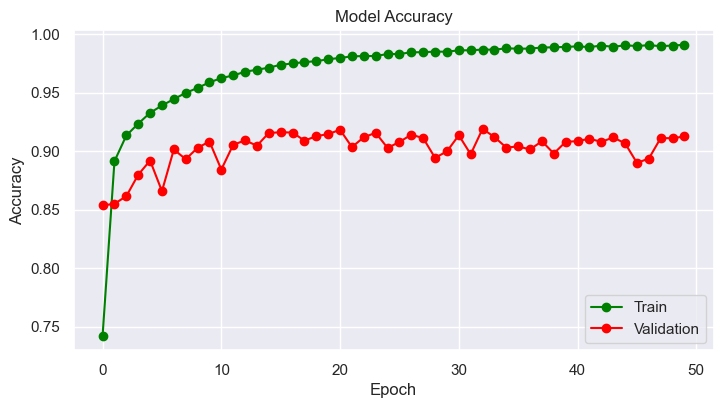

In [22]:
#  "Accuracy"
plt.figure(figsize=[8, 4])
sns.set_theme()
plt.plot(history_1.history['accuracy'], 'o-', color="Green")
plt.plot(history_1.history['val_accuracy'] , 'o-', color="Red")
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
#plt.show()
plt.gca().set_position([0.1, 0.12, 0.8, 0.8])
plt.savefig(r'H:\CVPR\Graph\SimpleDenseAccuracy1.svg')
plt.savefig(r'H:\CVPR\Graph\SimpleDenseAccuracy1.png')

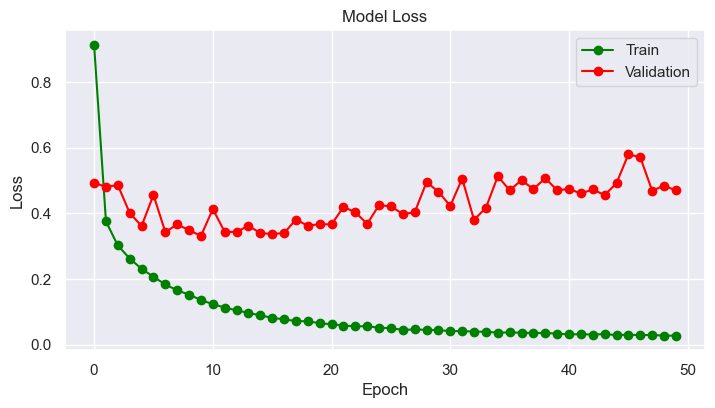

In [23]:
# "Loss"
plt.figure(figsize=[8, 4])
sns.set_theme()
plt.plot(history_1.history['loss'], 'o-', color="Green")
plt.plot(history_1.history['val_loss'], 'o-', color="Red")
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
#plt.show()
plt.gca().set_position([0.1, 0.12, 0.8, 0.8])
plt.savefig(r'H:\CVPR\Graph\SimpleDenseLoss1.svg')
plt.savefig(r'H:\CVPR\Graph\SimpleDenseLoss1.png')

In [24]:
%matplotlib inline
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

In [25]:
batch_size=20

In [26]:
Y_pred = model.predict_generator(validation_generator, num_validation_samples// batch_size+1)
print(Y_pred.shape)
y_pred = np.argmax(Y_pred, axis=1)
y_true= validation_generator.classes

target_names = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21','22','23','24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41','42','43', '44', '45', '46', '47', '48', '49', '50']
print(classification_report(y_true, y_pred, target_names=target_names, digits=3))

C:\Users\va5to\AppData\Local\Temp\ipykernel_11000\1346516700.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model.predict_generator(validation_generator, num_validation_samples// batch_size+1)


(14824, 50)
              precision    recall  f1-score   support

           1      0.916     0.959     0.937       296
           2      0.986     0.926     0.955       297
           3      0.945     0.929     0.937       297
           4      0.926     0.929     0.928       297
           5      0.924     0.786     0.850       295
           6      0.953     0.949     0.951       297
           7      0.683     0.889     0.772       296
           8      0.912     0.909     0.911       297
           9      0.907     0.923     0.915       297
          10      0.935     0.926     0.931       297
          11      0.933     0.936     0.934       297
          12      0.976     0.949     0.962       297
          13      0.951     0.923     0.937       297
          14      0.966     0.943     0.954       298
          15      0.966     0.946     0.956       296
          16      0.967     0.897     0.930       291
          17      0.858     0.771     0.812       297
          18   

In [27]:
cm = confusion_matrix(y_true, y_pred)

In [28]:
classes=50

In [29]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.BuGn
                         ):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(12,12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1]), ):
        plt.text(j, i, cm[i, j, ],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
    

In [30]:
import imp
imp.reload(sns)

C:\Users\va5to\AppData\Local\Temp\ipykernel_11000\31953510.py:1: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  import imp


<module 'seaborn' from 'C:\\Users\\va5to\\anaconda3\\lib\\site-packages\\seaborn\\__init__.py'>

In [31]:
sns.reset_defaults()

In [32]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib.font_manager import FontProperties

# plt.figure() 
# prop = FontProperties()
# prop.set_file('Siyamrupali.ttf')

In [33]:
cm_plot_labels = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21','22','23','24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41','42','43', '44', '45', '46', '47', '48', '49', '50']
#sns.set_theme()
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')
plt.savefig(r'H:\CVPR\Graph\SimpleDenseCNF1.svg')
plt.savefig(r'H:\CVPR\Graph\SimpleDenseCNF1.png')

Confusion matrix, without normalization
[[284   0   0 ...   0   0   0]
 [  1 275   0 ...   0   3   0]
 [  1   2 276 ...   0   0   1]
 ...
 [  1   0   0 ... 275   0   0]
 [  0   0   0 ...   0 282   0]
 [  1   0  12 ...   0   4 267]]
